# Model implementation for a single subject:

In [3]:
import pandas as pd
import numpy as np
import math
import os
import sys

## Importing custom functions from different folder:

In [16]:
# Get the current directory
current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)
folder = 'Implementation'
data_folder = os.path.join(parent_dir, folder)

# Construct the full file path
file_ = 'utils_data'
full_path = os.path.join(data_folder, file_)
print(full_path)
print(data_folder)
sys.path.append(data_folder)  

# Load the functions from .py file  
try:
    #from utils_data import load_data, data_clustering, plot_data, cleaning_data, linear_transf
    #from utils_data import experimental_velocity, plot_velocity, saving_processed_data
    from utils_data import load_processed_data, saving_processed_data
    from utils_model import numericalSimulation, ComputeFunctional, ComputeVel
    from utils_model import generate_trajectory, plot_simulation, generate_trajectory_vel, optimize_Sigma, plot_multiple_trajectories
    
    from utils_model_multiple import plotting_params, box_plot_params, plot_gaussian_distributions_theo, fitParamaters
    
except ModuleNotFoundError as e:
    print("ModuleNotFoundError:", e)

/Users/flaviaferrusmarimon/UB/MAM/TFM/Codes1/MotorControlPrediction/Implementation/utils_data
/Users/flaviaferrusmarimon/UB/MAM/TFM/Codes1/MotorControlPrediction/Implementation


## Data exploration

The data considered on this notebook contains the trajectories for a single subject, for all the possible configurations, and for the different possible targets.

## Reproducing results

We can reproduce our results in this Notebook by setting the initial parameters as well as on the `main.py` file. 

Set the following parameters according to the study you wish to conduct: 
- `processing` when set to `True` it conducts the whole processing process from the raw data. This includes: 
    - `data_clustering`: 
        - Classifying the data in 4 clusters, depending on the target they cross using a RNN classifying algorithm. 
    - `cleaning_data`: 
        - Cleaning the trajectories which do not cross the target and truncating the ones which do cross it. Also storing the optimal time in which they reach the target, $T^*$, stored in `idxrule`
    - `linear_transf`:
        - Rotating the needed trajectories and scaling them in order to get normalized data
        - Computing the mean velocity and the velocity profiles for each trajectory

- `fitting` when set to `True` the fitting of the parameters is conducted with the already processed data. This includes: 
    - `fitParamaters`: 
        - Sequential approach: 
            1. Optimal movement duration: Generate the optimal trajectory by optimizing the Functional in terms of the time T 
            2. Optimal controller: generate the optimal trajectory with the optimal time duration by minimizing the functional in terms of the biomechanical parameters $(\alpha, \gamma, \varepsilon)$. 
            3. Stochastic optimization: generate the optimal trajectory with optimal time duration and biomechanical parameters by optimizing the Kolmogorov Sirnov estimate in terms of the sigma 
        - Saving the obtained parameters

- `plotting` when set to `True` all the trajectory plots and prints are explicitly shown on this Notebook
- `saving` when set to `True` all the plots and data processed is saved. 

In [10]:
processing = False
fitting = True
plotting = True
saving = False

# Loading processed data: 

In [5]:
if not processing:
    # Loading the processed data: 
    print('Loading processed data...')
    n_clusters = 4
    dfx = [[] for _ in range(n_clusters)]
    dfy = [[] for _ in range(n_clusters)]
    for cluster in range(n_clusters): 
        dfx[cluster] = load_processed_data(folder_path='processed_data', file_name='cluster{}_dfx.csv'.format(cluster))
        dfy[cluster] = load_processed_data(folder_path='processed_data', file_name='cluster{}_dfy.csv'.format(cluster))
    results = load_processed_data(folder_path='processed_data', file_name='results.csv') 

Loading processed data...


In [6]:
results

,cluster,rectx,recty,idxrule,mean_T,max_vel
0,0,[ 9.5 10.75 11.5 12.75],[6.6 7.6 3.1 4.1],"[1814, 1404, 1654, 1791, 1291, 1672, 1632, 171...",1.319448,0.005534
1,1,[-12. -13.25 -10. -11.25],[-3.25 -4.25 -6.75 -7.75],"[1698, 1554, 1868, 1708, 1313, 1274, 1455, 141...",1.295982,0.005831
2,2,[11.5 12.75 9.5 10.75],[ 1.75 0.75 -1.75 -2.75],"[1487, 1293, 1305, 1366, 1198, 1132, 1353, 128...",1.251862,0.004535
3,3,[ -9.5 -10.75 -11.5 -12.75],[ 3. 4. -0.5 0.5],"[2042, 1197, 1369, 1063, 1131, 1495, 1305, 112...",1.304000,0.004591


# Parameter fitting: 

## Computing trajectories for optimized velocity for each cluster

In [ ]:
if fitting: 
    print('Fitting paramaters for the optimized trajectory...')   
    new_params, opt_sigma = fitParamaters(results, dfx, dfy, plotting = plotting, saving = saving)  
    combined_params = [] 
    for cluster in range(n_clusters):
        if plotting: 
            plot_multiple_trajectories(dfx[cluster], dfy[cluster], cluster = cluster, 
                               new_params = new_params[cluster], opt_Sigma = opt_sigma[cluster], 
                               pic_name = 'Simulated and experimental data', saving_plot = True)
        combined_params.append(np.hstack((new_params[cluster].x, opt_sigma[cluster].x)))
    parameters_fitted = pd.DataFrame(combined_params)
    params_fitted = np.array(combined_params)
    saving_processed_data(parameters_fitted, folder_name = 'fitted_data', file_name = 'fitted_parameters')
    if plotting: 
        box_plot_params(params_fitted)

Computing trajectory with optimized velocity for cluster:  0


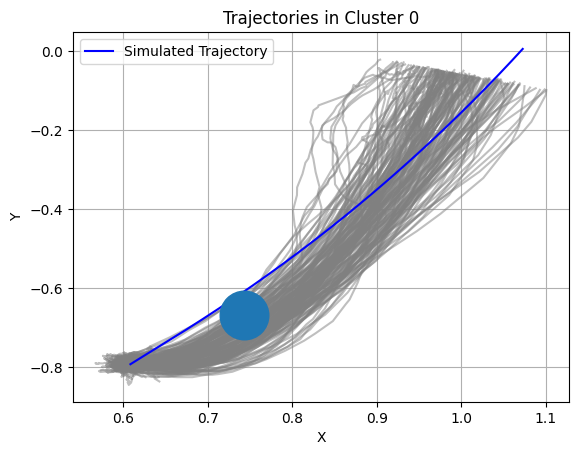

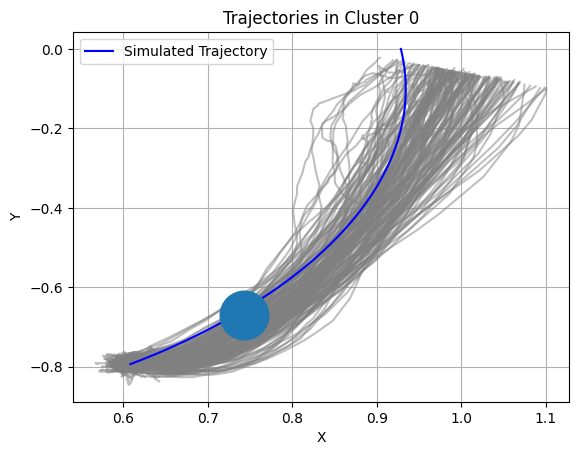

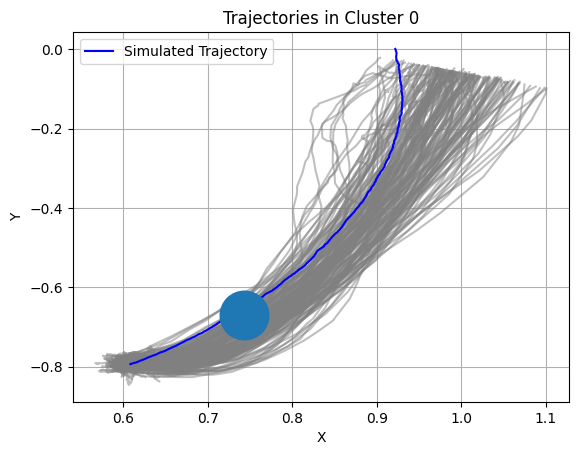

Parameters estimated:
[ 2.95749222  3.05271805 -3.21789397] 0.24611429050438055
Computing trajectory with optimized velocity for cluster:  1


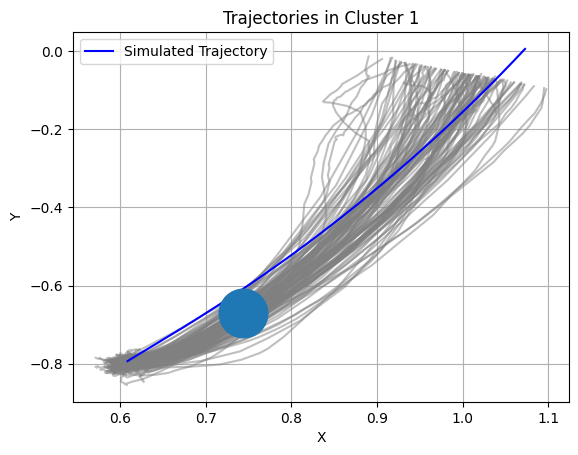

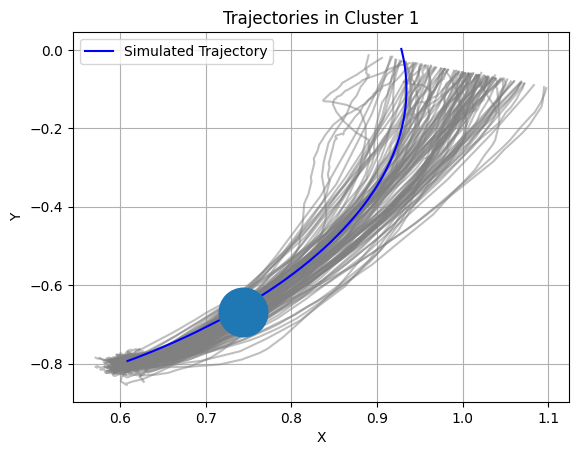

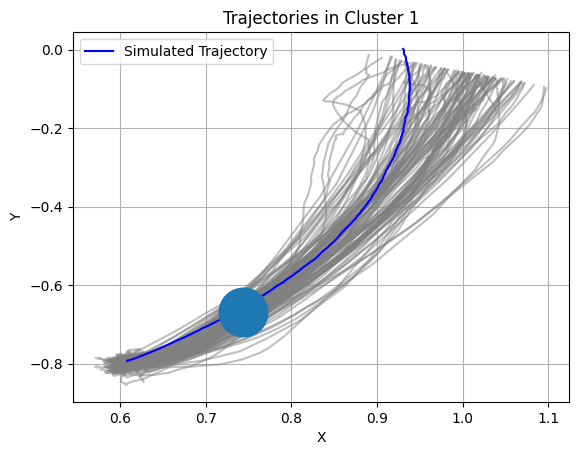

Parameters estimated:
[ 2.96624475  3.0617932  -3.22741432] 0.20932104499044796
Computing trajectory with optimized velocity for cluster:  2


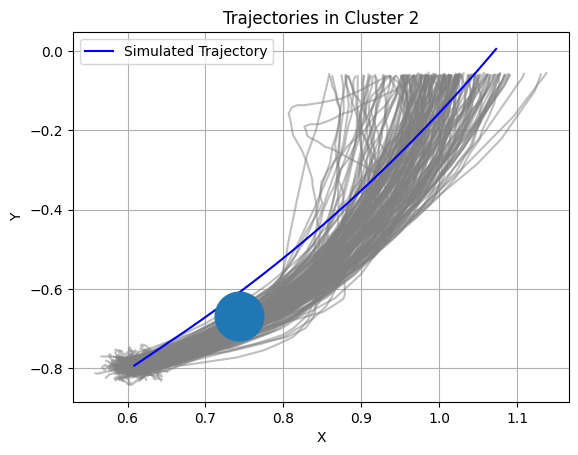

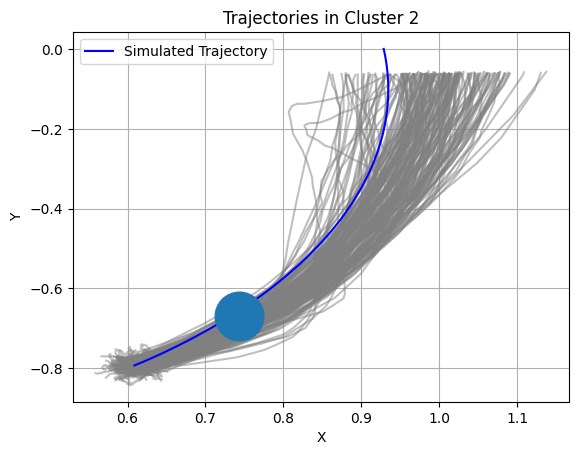

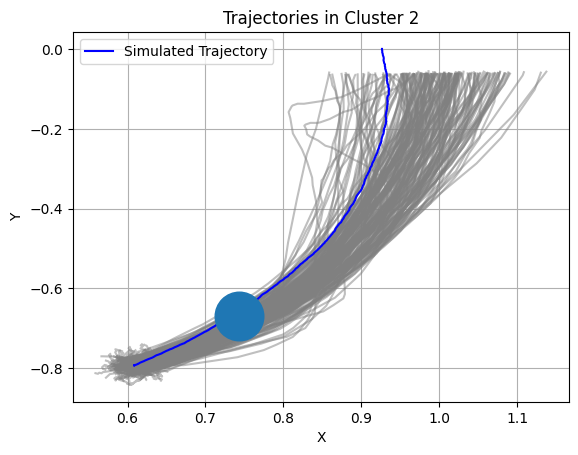

Parameters estimated:
[ 2.95038819  3.04836258 -3.21082698] -0.2522943170963998
Computing trajectory with optimized velocity for cluster:  3


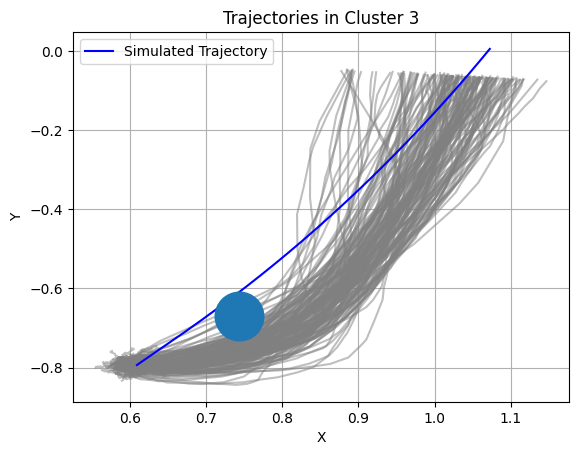

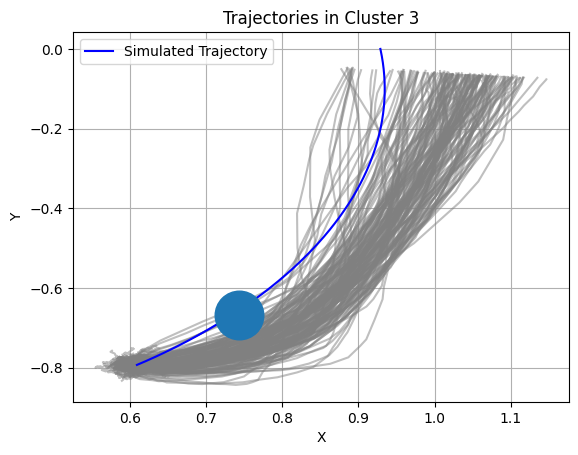

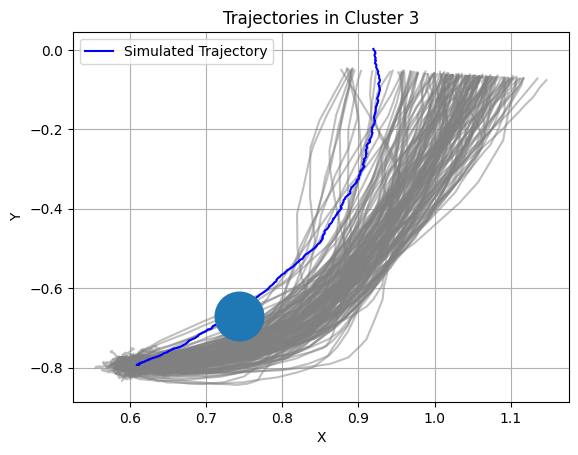

Parameters estimated:
[ 2.93367308  3.03112578 -3.18704439] 0.41641154749469533


In [12]:
if fitting:
    new_params = [[] for _ in range(n_clusters)]
    opt_sigma = [[] for _ in range(n_clusters)]

    for cluster in range(n_clusters):
        print('Computing trajectory with optimized velocity for cluster: ', cluster)
        
        ## Generate the optimal trajectory by optimizing the Functional in terms of the time T 
        x, y, T, parameters_0 = generate_trajectory(plotting = False)
        if plotting:
            plot_simulation(x, y, dfx[cluster], dfy[cluster], 
                        cluster = cluster, pic_name = 'Trajectories_optFunctional', 
                        saving_plot = saving)
        
        ## Generate the optimal trajectory with the time provided from optimizing the Functional 
        # by optimizing the velocity in terms of the parameters (alpha, epsilon, gamma)
        x_, y_, new_params[cluster] = generate_trajectory_vel(plotting = False, 
                                    T = T,
                                    vel = results[results['cluster'] == cluster].max_vel.values[0])
        if plotting:
            plot_simulation(x_, y_, dfx[cluster], dfy[cluster], 
                        cluster = cluster, pic_name = 'Trajectories_optVel', 
                        saving_plot = saving)
        
        ## Generate the optimal trajectory with the optimum stopping time and parameters
        # by optimizing the Kolmogorov Sirnov estimate in terms of the sigma
            # Converting idxrule to array from string
        idxr = results[results['cluster'] == cluster].idxrule.values[0]
        idxrule = np.fromstring(idxr[1: -1], dtype = int, sep = ', ')
        
        x__, y__, opt_sigma[cluster] = optimize_Sigma(dfx[cluster] , dfy[cluster],
                                            idxrule = idxrule, 
                                            new_params = new_params[cluster])
        if plotting: 
            plot_simulation(x__, y__, dfx[cluster], dfy[cluster], 
                        cluster = cluster, pic_name = 'Trajectories_optSigma', 
                        saving_plot = saving)
        
        print('Parameters estimated:')
        print(new_params[cluster].x, opt_sigma[cluster].x)
        

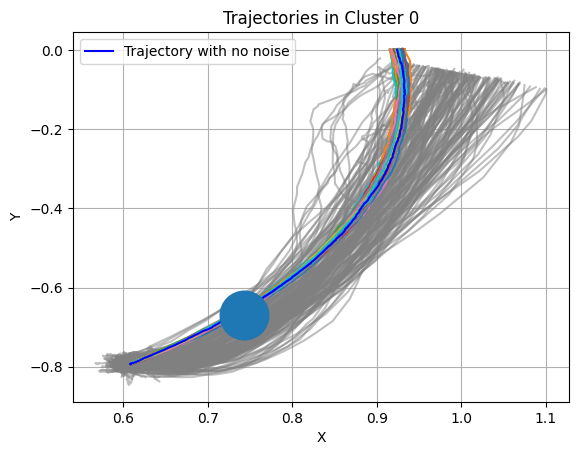

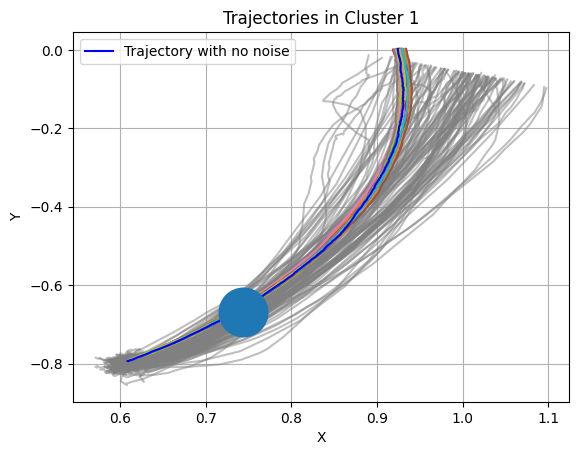

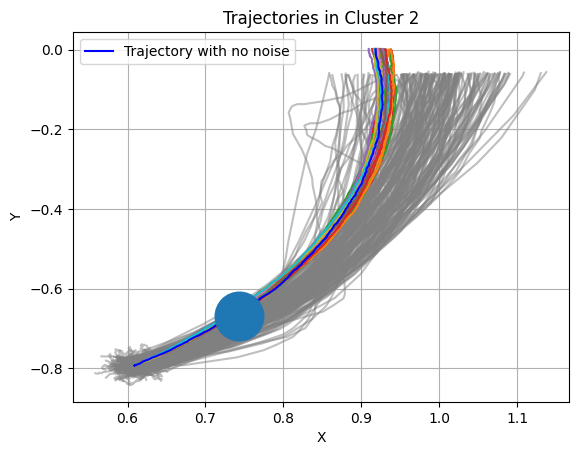

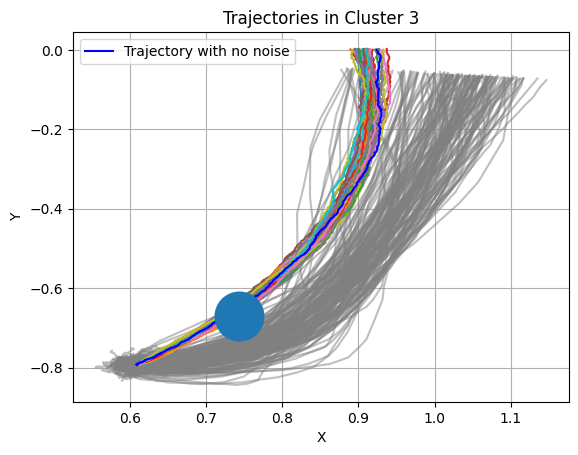

In [13]:
for cluster in range(n_clusters):
    plot_multiple_trajectories(dfx[cluster], dfy[cluster], cluster = cluster, 
                               new_params = new_params[cluster], opt_Sigma = opt_sigma[cluster], 
                               pic_name = 'Simulated and experimental data', saving_plot = True)

In [14]:
for cluster in range(n_clusters):
    print(new_params[cluster].x, opt_sigma[cluster].x)

[ 2.95749222  3.05271805 -3.21789397] 0.24611429050438055
[ 2.96624475  3.0617932  -3.22741432] 0.20932104499044796
[ 2.95038819  3.04836258 -3.21082698] -0.2522943170963998
[ 2.93367308  3.03112578 -3.18704439] 0.41641154749469533


In [22]:
combined_params = []
for cluster in range(n_clusters):
    combined_params.append(np.hstack((new_params[cluster].x, opt_sigma[cluster].x)))
    
print(combined_params)
print(type(combined_params))

[array([ 2.95749222,  3.05271805, -3.21789397,  0.24611429]), array([ 2.96624475,  3.0617932 , -3.22741432,  0.20932104]), array([ 2.95038819,  3.04836258, -3.21082698, -0.25229432]), array([ 2.93367308,  3.03112578, -3.18704439,  0.41641155])]
<class 'list'>


In [28]:
saving_processed_data(pd.DataFrame(combined_params), folder_name = 'fitted_data', file_name = 'fitted_parameters')

In [39]:
parameters_fitted = pd.DataFrame(combined_params)
params_fitted = np.array(combined_params)
print(params_fitted.shape)
parameters_fitted

(4, 4)


,0,1,2,3
0,2.957492,3.052718,-3.217894,0.246114
1,2.966245,3.061793,-3.227414,0.209321
2,2.950388,3.048363,-3.210827,-0.252294
3,2.933673,3.031126,-3.187044,0.416412


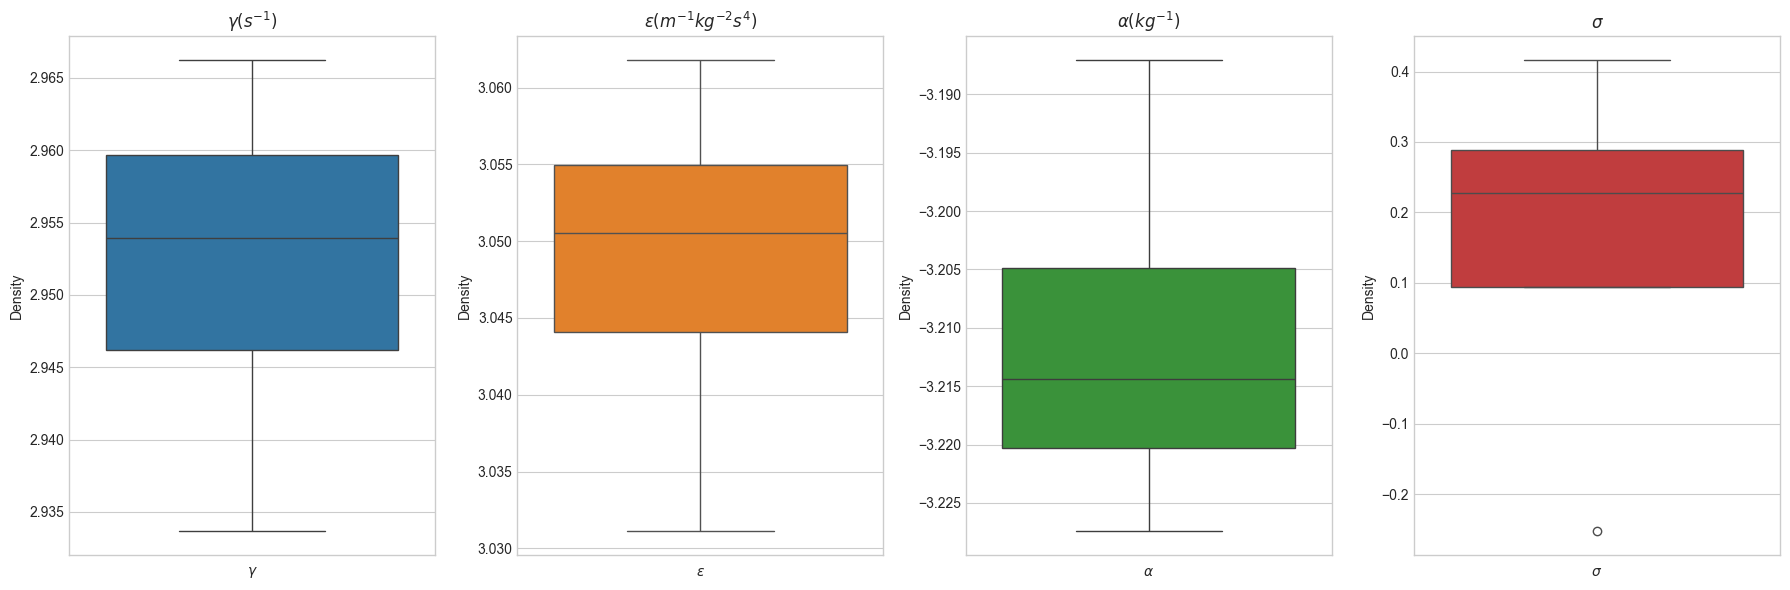

In [41]:
box_plot_params(params_fitted)

In [11]:
## Parameters obtained from this subject for the 4 different movements: 

params = np.array([
    [2.95749222,  3.05271805, -3.21789397, 0.27243061639444527],
    [2.96624475,  3.0617932,  -3.22741432, 0.3815129361113957],
    [2.95038819,  3.04836258, -3.21082698, 0.29682106532693353],
    [2.93367308,  3.03112578, -3.18704439, 0.3725986486762996]
])


# Functions

In [25]:
import scipy
import matplotlib.pyplot as plt
from typing import Tuple

def plot_trajectory(x, y, showing = True, via = True, plot_title = 'Simulated Trajectory'):
    '''
        Function that plots the given trajectory (x(t), y(t)). 
    ''' 
    plt.plot(x,y,color='blue', label=plot_title, alpha = 1)
    if via:
        angle=math.pi*7/24
        T_1=.2
        plt.plot(np.cos(angle*(T_1-1)),np.sin(angle*(T_1-1)),marker='o',markersize=35)
    if showing: 
        plt.show()

def generate_trajectory_vel_(params=(.5, .1, .5), parameters=(3.7, -0.15679707, 0.97252444, 0.54660283, -6.75775885, -0.06253371),
                            sigma=0, timestep=1/500, plotting=True, T=1.3, vel=0.1) -> Tuple[np.ndarray, np.ndarray]:
    partial_compute_vel = lambda params: ComputeVel(params, vel=vel, T=T, sigma=sigma)
    
    bounds = [(0.01, 10), (0.01, 1), (0.01, 1)]  # Bounds for gamma, epsilon, alpha
    
    result = scipy.optimize.minimize(partial_compute_vel, params, bounds=bounds, method='L-BFGS-B')
    
    gamma, epsilon, alpha = result.x
    x, y, v, w, ux, uy, T = numericalSimulation(
        x_0=(0,0,0,0), p_T=1.0, sigma=sigma, gamma=gamma, epsilon=epsilon, alpha=alpha,
        u_0=parameters[:2], l_0=parameters[2:], i_max=1000, dt=timestep,
        Autoregr=True, Arc=True, angle=np.pi*7/24, angle0=0, p=(.2,0), r=.1
    )
    
    if plotting:
        plot_trajectory(x, y, showing=True)
        
    return x, y, result


Computing trajectory with optimized velocity for cluster:  0


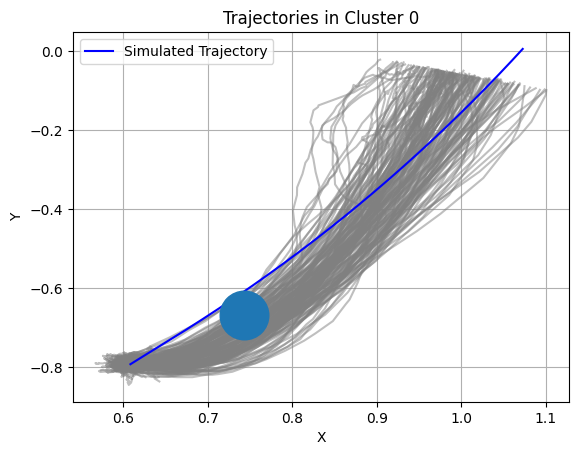

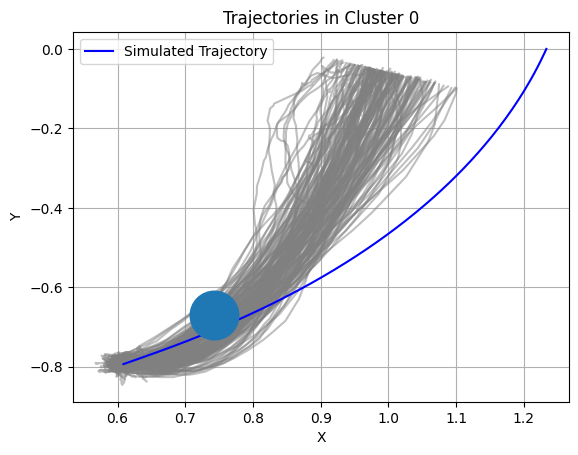

[10.         1.         0.0878486]
Computing trajectory with optimized velocity for cluster:  1


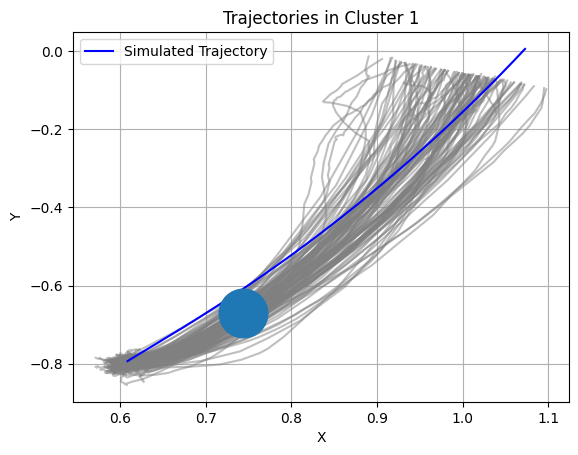

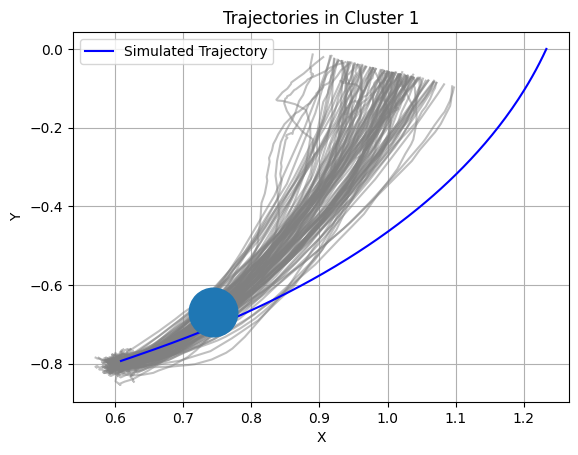

[10.          1.          0.08789306]
Computing trajectory with optimized velocity for cluster:  2


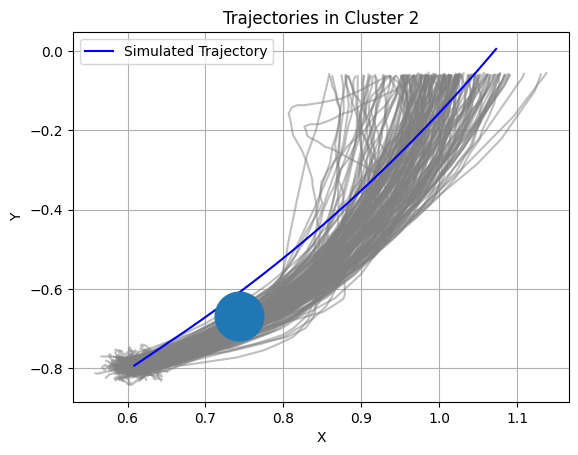

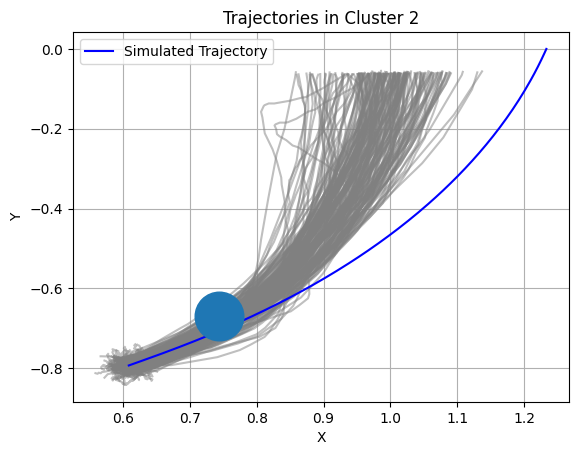

[10.         1.         0.0878494]
Computing trajectory with optimized velocity for cluster:  3


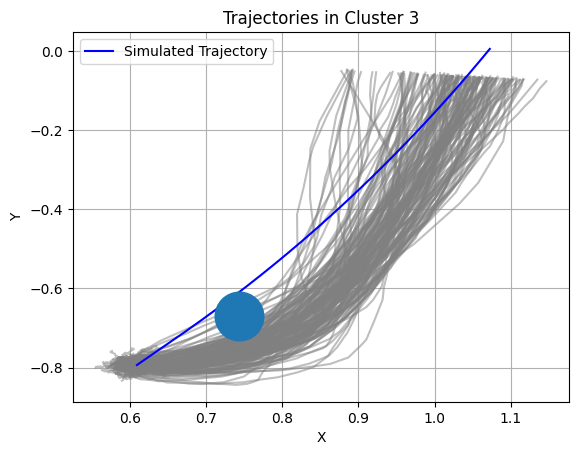

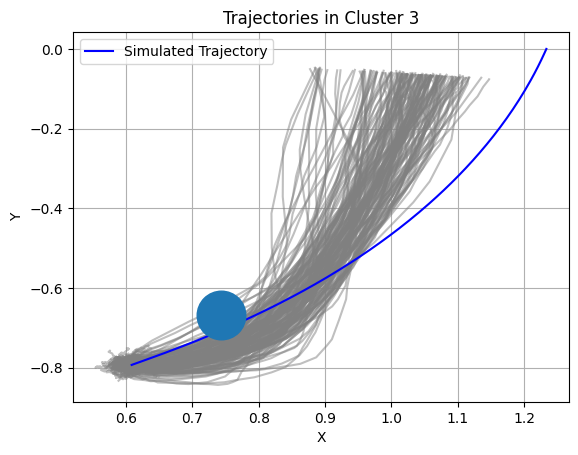

[10.          1.          0.08784861]


In [26]:
new_params = [[] for _ in range(n_clusters)]
opt_sigma = [[] for _ in range(n_clusters)]

for cluster in range(n_clusters):
    print('Computing trajectory with optimized velocity for cluster: ', cluster)
    
    ## Generate the optimal trajectory by optimizing the Functional in terms of the time T 
    x, y, T = generate_trajectory(plotting = False)
    plot_simulation(x, y, dfx[cluster], dfy[cluster], 
                    cluster = cluster, pic_name = 'Trajectories_optFunctional', 
                    saving_plot = False)
    
    ## Generate the optimal trajectory with the time provided from optimizing the Functional 
    # by optimizing the velocity in terms of the parameters (alpha, epsilon, gamma)
    x_, y_, new_params[cluster] = generate_trajectory_vel_(plotting = False, 
                                 T = T,
                                 vel = results[results['cluster'] == cluster].max_vel.values[0])
    plot_simulation(x_, y_, dfx[cluster], dfy[cluster], 
                    cluster = cluster, pic_name = 'Trajectories_optVel', 
                    saving_plot = False)
    print(new_params[cluster].x)

In [27]:
new_params[cluster]

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 17.573956227849475
        x: [ 1.000e+01  1.000e+00  8.785e-02]
      nit: 12
      jac: [-9.278e-02 -3.517e+01  2.282e+00]
     nfev: 316
     njev: 79
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>